# Comparative Lyrical Analysis of Artists

## Team Members
- Prapti Patel
- Aden Pessin


## Project Goals

This project aims to perform a comprehensive comparative analysis of lyrical content from a couple artists

### Objectives:
1. **Data Collection**: Retrieve song lyrics from the Genius API for each artist, focusing on solo tracks
2. **Text Processing**: Clean and prepare lyrics data for natural language analysis
3. **Feature Extraction**: Analyze vocabulary richness, word frequency, and sentiment patterns
4. **Comparative Analysis**: Identify distinctive lyrical characteristics and thematic preferences across artists
5. **Visualization**: Create compelling visual representations of lyrical patterns including word clouds, sentiment distributions, and keyword usage
6. **Clustering**: Apply machine learning techniques to discover natural groupings in song characteristics

### Research Questions:
- What are top most used words used by a selection of artists?
- Top 10 words of all artists selected?
- How does sentiment vary between artists?
- Which artist has the most complex vocabulary (unique words per song)?




In [1]:
# Remove unneeded imports before submission
import requests
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from collections import Counter

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

---
# Data Import and Collection

This section handles all data collection from the Genius API, including:
- Setting up API authentication
- Searching for artists and retrieving their song catalogs
- Scraping lyrics from Genius web pages
- Filtering to ensure only solo tracks are included

In [2]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')  # required for word_tokenize in newer NLTK versions
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ampes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ampes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ampes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ampes\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
BASE_URL = "https://api.genius.com"
TOKEN = "7PAIkzLxC9esEk4oUwJM1cAo9o6cWo2-tvxqtN1kz3Tfduwjhhf-uUDyE76WV9ws"
HEADERS = {"Authorization": f"Bearer {TOKEN}"}

## API Configuration

In [4]:
def search_artist(artist_name):
    """Search for an artist on Genius and return their unique ID"""
    # Build the search endpoint URL
    url = f"{BASE_URL}/search"
    params = {"q": artist_name}
    
    # Make API request and parse JSON response
    response = requests.get(url, headers=HEADERS, params=params).json()
    hits = response['response']['hits']
    
    # Loop through search results to find exact artist match
    for hit in hits:
        # Compare artist names (case-insensitive)
        if hit['result']['primary_artist']['name'].lower() == artist_name.lower():
            # Return the artist's unique ID
            return hit['result']['primary_artist']['id']
    
    # Return None if artist not found
    return None

## Helper Functions for Data Retrieval

In [5]:
def get_artist_songs(artist_id, per_page=50, max_pages=5):
    songs = []
    for page in range(1, max_pages+1):
        url = f"{BASE_URL}/artists/{artist_id}/songs"
        params = {"per_page": per_page, "page": page}
        response = requests.get(url, headers=HEADERS, params=params).json()
        songs += response['response']['songs']
    return songs

In [6]:
def get_lyrics(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    lyrics = soup.find('div', class_=re.compile('Lyrics__Container'))
    if lyrics:
        return lyrics.get_text(separator=" ")
    return ""

In [7]:
artists = ["Taylor Swift", "Kanye West", "Billie Eilish", "Zach Bryan", "Eminem"]

## Define Artists and Collect Data

In [8]:
all_songs = []
seen_songs = set()  # Track unique songs to avoid duplicates

for artist in artists:
    artist_id = search_artist(artist)
    songs = get_artist_songs(artist_id, per_page=50, max_pages=2)  # limit to 100 songs
    for song in songs:
        # Skip if song already processed (based on song ID)
        if song['id'] in seen_songs:
            continue
        
        # Only include songs where this artist is the sole primary artist
        if song['primary_artist']['id'] != artist_id:
            continue
        
        # Skip songs with featured artists (check title for "feat." or "&")
        title = song['title'].lower()
        if 'feat' in title or '&' in title or 'with' in title:
            continue
        
        # Skip if featured_artists list exists and is not empty
        if song.get('featured_artists') and len(song['featured_artists']) > 0:
            continue
        
        lyrics = get_lyrics(song['url'])
        
        # Skip songs with no lyrics
        if not lyrics or len(lyrics.strip()) < 50:
            continue
        
        all_songs.append({
            'artist': artist,
            'title': song['title'],
            'album': song.get('album', {}).get('name', None),
            'release_date': song.get('release_date', None),
            'lyrics': lyrics
        })
        
        seen_songs.add(song['id'])

df = pd.DataFrame(all_songs)
print(f"Total songs collected: {len(df)}")
print(f"Songs per artist:\n{df['artist'].value_counts()}")


Total songs collected: 250
Songs per artist:
artist
Zach Bryan       88
Taylor Swift     52
Billie Eilish    46
Eminem           37
Kanye West       27
Name: count, dtype: int64


---
# Data Processing and Feature Engineering

This section prepares the raw lyrics data for analysis by:
- Cleaning and normalizing text
- Extracting linguistic features (word counts, vocabulary richness, average word length)
- Computing sentiment scores using VADER sentiment analysis

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # remove brackets
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['clean_lyrics'] = df['lyrics'].apply(clean_text)

# Ensure required NLTK resources are available in this environment
# Needed for running correctly
_required = [
    ("punkt", "tokenizers/punkt"),
    ("punkt_tab", "tokenizers/punkt_tab"),
    ("stopwords", "corpora/stopwords"),
]
# for troubleshooting issues
for res, path in _required:
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(res, quiet=True)

stop_words = set(stopwords.words('english'))

# Add custom filler words common in lyrics
custom_filler_words = {
    'like', 'th', 'im', 'got', 'get', 'oh', 'yeah', 'na', 'ooh', 'ah', 'uh',
    'gonna', 'wanna', 'gotta', 'em', 'cause', 'ill', 'dont', 'cant', 'aint',
    'wouldnt', 'couldnt', 'didnt', 'doesnt', 'isnt', 'wasnt', 'werent', 'youre',
    'theyre', 'thats', 'whats', 'hes', 'shes', 'its', 'id', 'youd', 'wed',
    'la', 'da', 'ya', 'yo', 'ey', 'ay', 'uh', 'mmm', 'hmm', 'huh', 'contributor',
    'embed','lyrics', 'verse', 'chorus', 'contributors', 'ive'
}
stop_words = stop_words.union(custom_filler_words)

def get_features(text):
    words = word_tokenize(text)
    words_no_stop = [w for w in words if w not in stop_words]
    unique_words = len(set(words_no_stop))
    total_words = len(words_no_stop)
    avg_word_len = np.mean([len(w) for w in words_no_stop]) if total_words > 0 else 0
    return pd.Series({'total_words': total_words, 'unique_words': unique_words, 'avg_word_len': avg_word_len})

df = df.join(df['clean_lyrics'].apply(get_features))


## Word Frequency Statistics

In [10]:
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['clean_lyrics'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [11]:
# Summary stats by artist
summary = df.groupby('artist')[['total_words', 'unique_words', 'avg_word_len', 'sentiment']].mean()
print(summary)

# Top 10 most common words per artist
def top_words(text, n=10):
    words = [w for w in word_tokenize(text) if w not in stop_words]
    return Counter(words).most_common(n)

for artist in artists:
    artist_text = " ".join(df[df['artist']==artist]['clean_lyrics'])
    print(f"Top words for {artist}: {top_words(artist_text)}")

               total_words  unique_words  avg_word_len  sentiment
artist                                                           
Billie Eilish    66.043478     50.695652      5.390111  -0.042611
Eminem          107.837838     91.459459      5.639790  -0.601430
Kanye West      106.703704     76.740741      5.254066   0.388630
Taylor Swift    124.576923     90.365385      5.529944   0.474985
Zach Bryan       80.693182     62.806818      4.988804   0.137625
Top words for Taylor Swift: [('usa', 116), ('love', 64), ('hey', 51), ('know', 45), ('one', 43), ('say', 37), ('time', 37), ('people', 36), ('stay', 36), ('never', 35)]
Top words for Kanye West: [('know', 48), ('right', 37), ('make', 30), ('people', 23), ('time', 22), ('gon', 21), ('go', 18), ('feel', 18), ('one', 17), ('want', 16)]
Top words for Billie Eilish: [('guy', 58), ('know', 49), ('billie', 47), ('bad', 45), ('song', 38), ('mind', 38), ('go', 28), ('love', 28), ('wheres', 28), ('make', 26)]
Top words for Zach Bryan: [('back

---
# Analysis and Visualization

## Machine Learning: K-Means Clustering

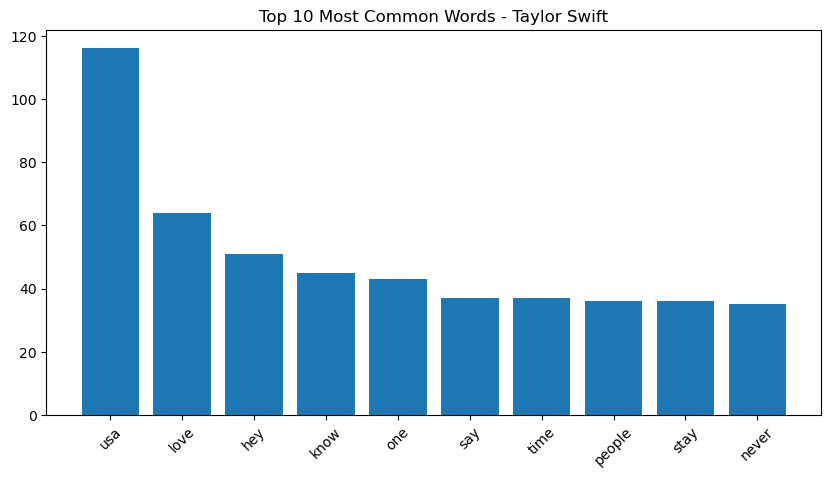

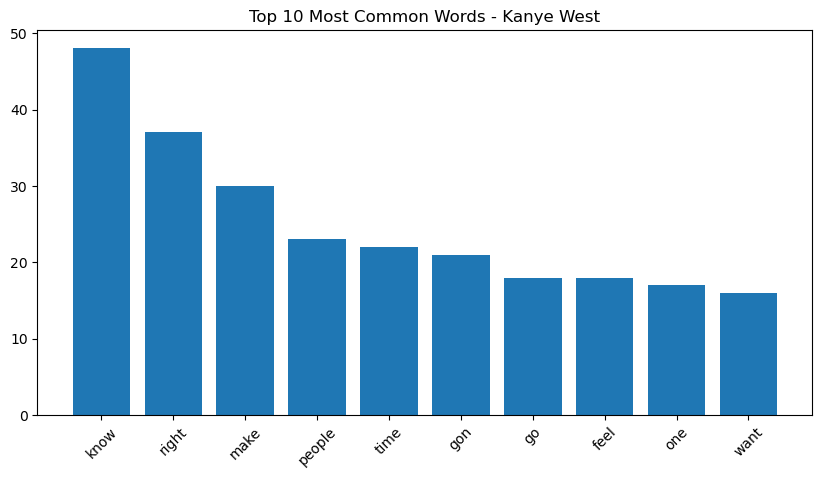

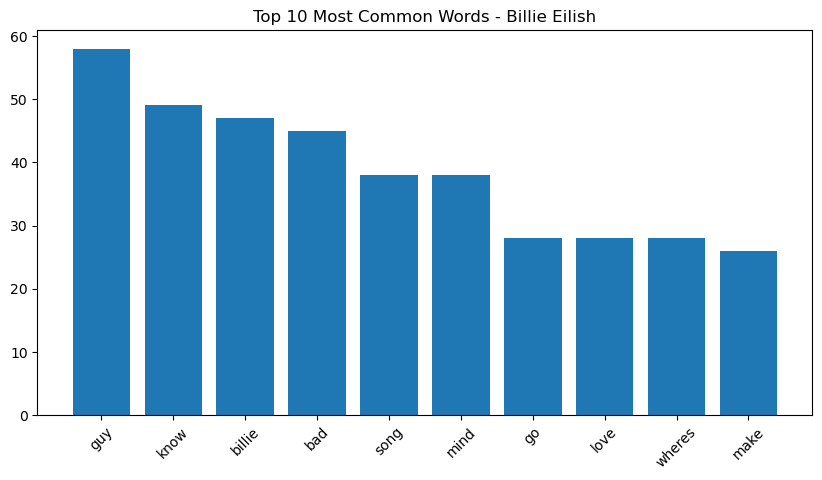

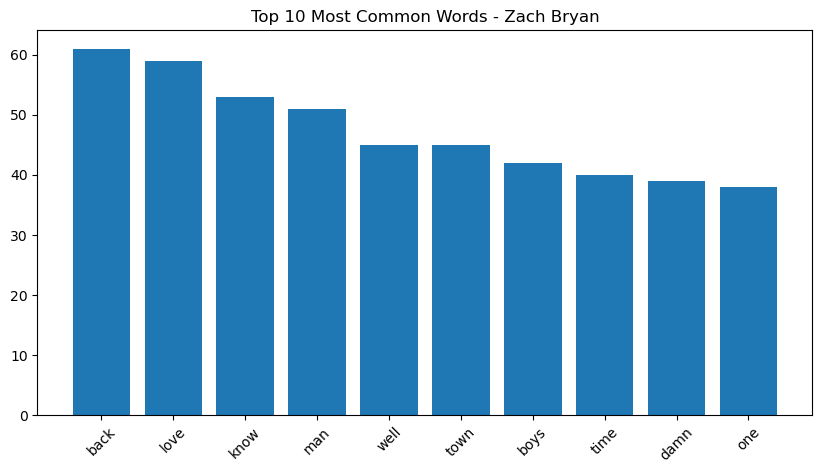

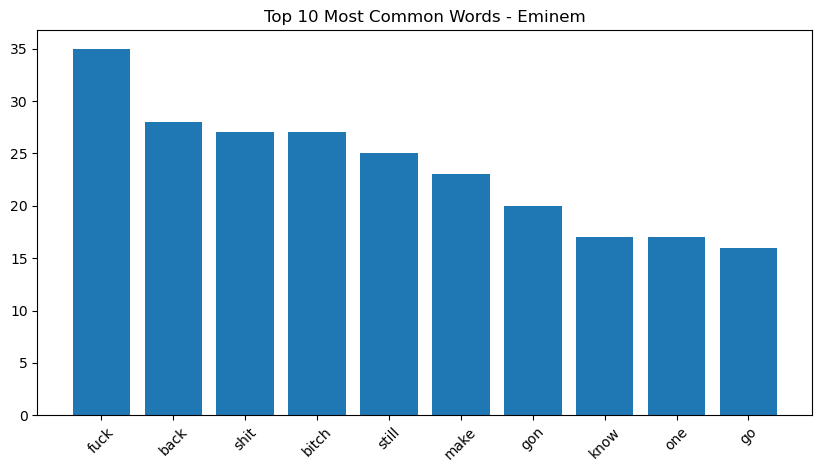

In [12]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_top_words(df, artist, n=10):
    # Bar chart of the most common words for a specific artist
    
    # Combine all lyrics for the artist
    text = " ".join(df[df['artist']==artist]['clean_lyrics'])
    
    # Tokenize and filter stop words
    words = [w for w in word_tokenize(text) if w not in stop_words]
    
    # Get the n most common words
    counts = Counter(words).most_common(n)
    words, freqs = zip(*counts)
    
    # Create bar chart
    plt.figure(figsize=(10,5))
    plt.bar(words, freqs)
    plt.title(f"Top {n} Most Common Words - {artist}")
    plt.xticks(rotation=45)
    plt.show()

# Generate bar charts for all artists
for artist in artists:
    plot_top_words(df, artist)

## Top Words Bar Charts by Artist

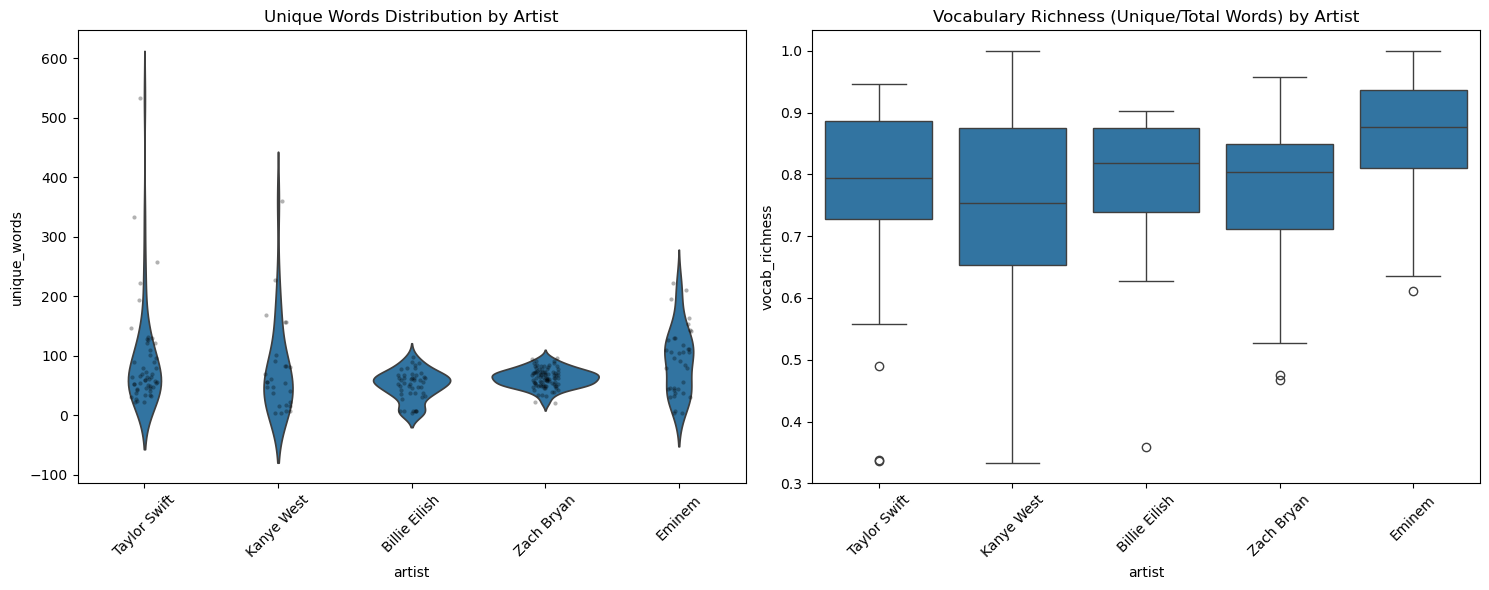

In [13]:
# Calculate vocabulary richness ratio (proportion of unique words)
df['vocab_richness'] = df['unique_words'] / df['total_words']

# Create a figure with two side-by-side visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Violin plot with individual data points overlaid
sns.violinplot(data=df, x='artist', y='unique_words', ax=axes[0], inner=None)
sns.stripplot(data=df, x='artist', y='unique_words', ax=axes[0], color='black', alpha=0.3, size=3)
axes[0].set_title("Unique Words Distribution by Artist")
axes[0].tick_params(axis='x', rotation=45)

# Right plot: Vocabulary richness ratio comparison
sns.boxplot(data=df, x='artist', y='vocab_richness', ax=axes[1])
axes[1].set_title("Vocabulary Richness (Unique/Total Words) by Artist")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Word Cloud for Each Artist

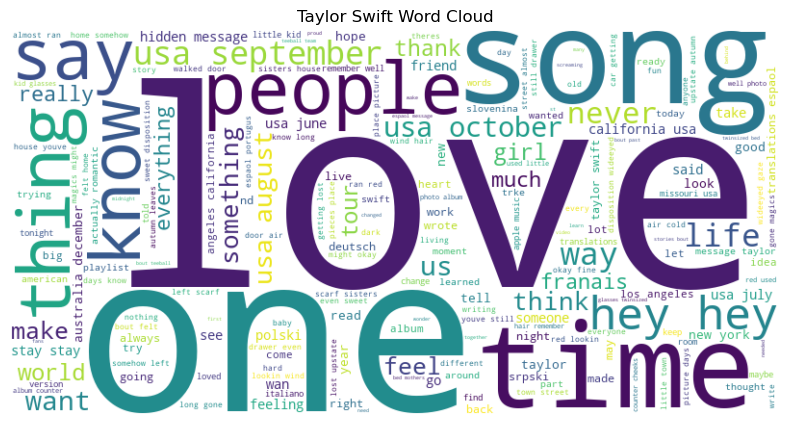

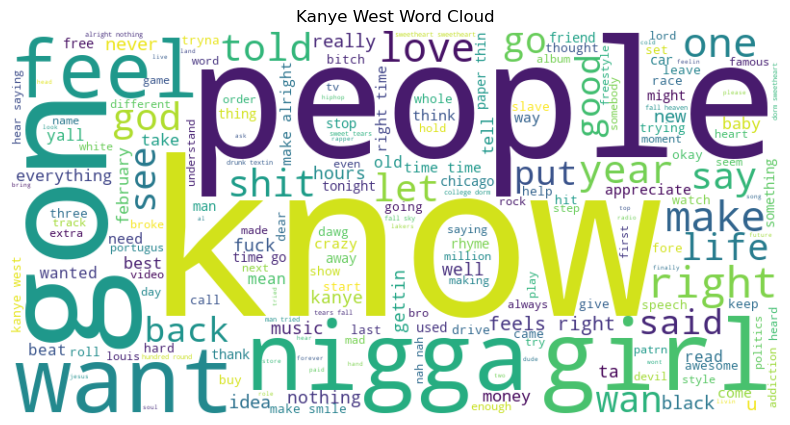

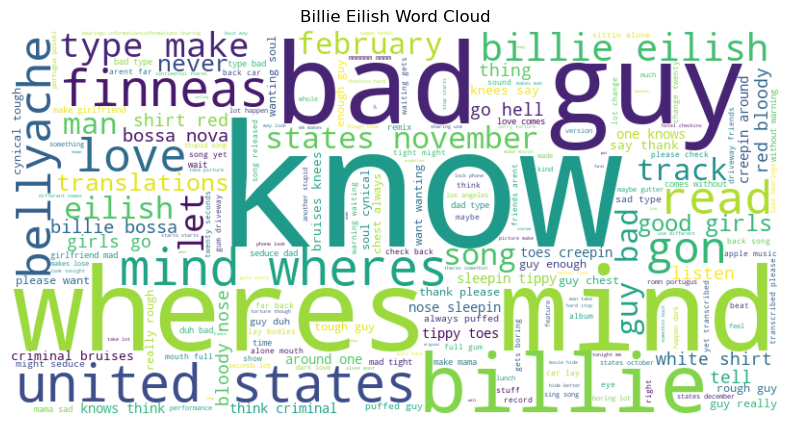

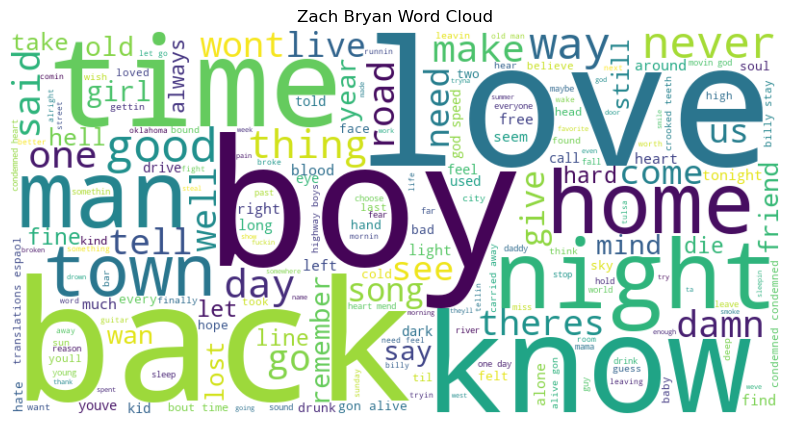

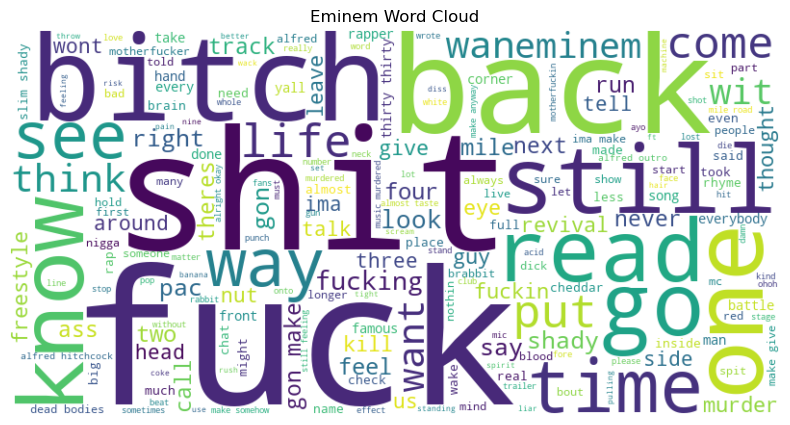

In [14]:
# Generate word clouds for each artist
for artist in artists:
    # Combine all lyrics from this artist
    artist_text = " ".join(df[df['artist']==artist]['clean_lyrics'])
    
    # Filter out stop words before generating word cloud
    words = [w for w in word_tokenize(artist_text) if w not in stop_words]
    filtered_text = " ".join(words)
    
    # Create and display word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{artist} Word Cloud")
    plt.show()

## Sentiment Distribution

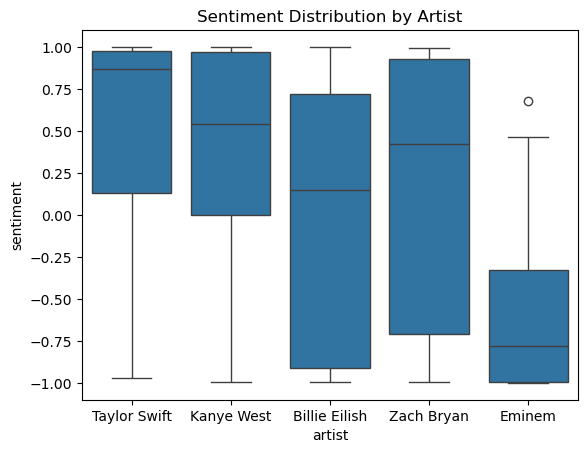

In [15]:
# Create boxplot to compare sentiment distributions across artists
sns.boxplot(x='artist', y='sentiment', data=df)
plt.title("Sentiment Distribution by Artist")
plt.show()

## Keyword Frequency Heatmap

Top 10 words across all artists:
  know: 212
  love: 168
  back: 145
  one: 131
  make: 125
  go: 121
  time: 121
  usa: 116
  say: 110
  never: 99

Using top 5 words for heatmap: ['know', 'love', 'back', 'one', 'make']



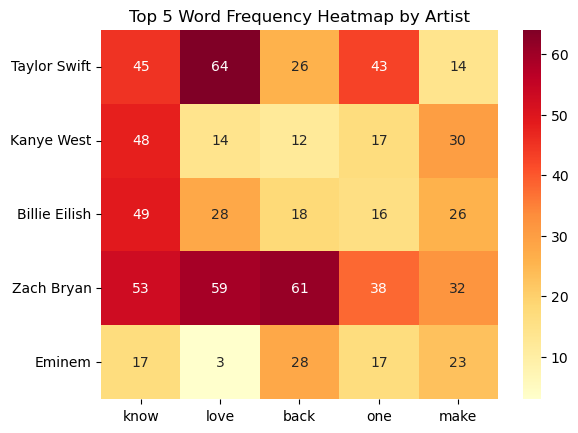

In [16]:
# Get top words across all artists combined
all_text = " ".join(df['clean_lyrics'])
all_tokens = [w for w in word_tokenize(all_text) if w not in stop_words]
word_counts = Counter(all_tokens)

# Print top 10 words with counts
print("Top 10 words across all artists:")
top_10 = word_counts.most_common(10)
for word, count in top_10:
    print(f"  {word}: {count}")
print()

# Extract top 5 words for heatmap visualization
top_5_words = [word for word, count in word_counts.most_common(5)]
print(f"Using top 5 words for heatmap: {top_5_words}\n")

# Create heatmap data: count occurrences of top 5 words per artist
heatmap = []
for artist in artists:
    # Combine all lyrics for this artist
    text = " ".join(df[df['artist']==artist]['clean_lyrics'])
    tokens = word_tokenize(text)
    # Count how many times each top word appears
    heatmap.append([tokens.count(w) for w in top_5_words])

# Display heatmap with integer annotations and color scale
sns.heatmap(pd.DataFrame(heatmap, index=artists, columns=top_5_words), annot=True, fmt='d', cmap='YlOrRd')
plt.title("Top 5 Word Frequency Heatmap by Artist")
plt.show()